Dieses Notebook stammt ursprünglich von Microsoft und wurde über GitHub als Projekt [Coginitve-Vision-Python](https://github.com/Microsoft/Cognitive-Vision-Python) bereitgestellt. Hier wurden ein paar Anpassungen gemacht...

# Project Oxford: Computer Vision API example

### This Jupyter notebook shows you how to get started with the Project Oxford <b>Computer Vision API</b> in Python, and how to visualize your results.

To use this notebook, you will need to get keys to <b>Computer Vision API</b>. Visit <a href="https://azure.microsoft.com/en-us/services/cognitive-services/computer-vision">https://azure.microsoft.com/en-us/services/cognitive-services/computer-vision</a>, and then the “Try Computer Vision API” button. On the “Sign in” page, use your Microsoft account to sign in and you will be able to subscribe to Computer Vision API and get free keys (Code of Conduct and TOS). After completing the sign-up process, paste your API key and API region into the variables section below. (Either the primary or the secondary key works.)

In [1]:
import time 
import requests
import cv2
import operator
import numpy as np
from __future__ import print_function

# Import library to display results
import matplotlib.pyplot as plt
%matplotlib inline 
# Display images within Jupyter

In [2]:
# Variables
_region = 'westeurope' #Here you enter the region of your subscription
_url = 'https://{}.api.cognitive.microsoft.com/vision/v1.0/analyze'.format(_region)
_key = 'ffea095cfb20426499353405b5f6d528' #Here you have to paste your primary key
_maxNumRetries = 10

## Helper functions

In [3]:
def processRequest( json, data, headers, params ):

    """
    Helper function to process the request to Project Oxford

    Parameters:
    json: Used when processing images from its URL. See API Documentation
    data: Used when processing image read from disk. See API Documentation
    headers: Used to pass the key information and the data type request
    """

    retries = 0
    result = None

    while True:

        response = requests.request( 'post', _url, json = json, data = data, headers = headers, params = params )

        if response.status_code == 429: 

            print( "Message: %s" % ( response.json() ) )

            if retries <= _maxNumRetries: 
                time.sleep(1) 
                retries += 1
                continue
            else: 
                print( 'Error: failed after retrying!' )
                break

        elif response.status_code == 200 or response.status_code == 201:

            if 'content-length' in response.headers and int(response.headers['content-length']) == 0: 
                result = None 
            elif 'content-type' in response.headers and isinstance(response.headers['content-type'], str): 
                if 'application/json' in response.headers['content-type'].lower(): 
                    result = response.json() if response.content else None 
                elif 'image' in response.headers['content-type'].lower(): 
                    result = response.content
        else:
            print( "Error code: %d" % ( response.status_code ) )
            print( "Message: %s" % ( response.json() ) )

        break
        
    return result

In [47]:
def print_result(result):
    if 'tags' in result:
        print('Tags:')
        for d in result['tags']:
            print(d['name'] + ' (' + str(d['confidence']) + ') ')

    if 'categories' in result:
        print('\nCategories:')
        for d in result['categories']:
            print(d['name'] + ' (' + str(d['score']) + ') ')


## Analysis of an image stored on disk

data/test/unknown/8987.jpg
Tags:
dog (0.998056828976) 
person (0.981134533882) 
sitting (0.974461734295) 
indoor (0.941959500313) 
animal (0.826019585133) 
mammal (0.823696196079) 
posing (0.407455801964) 

Categories:
others_ (0.01953125) 


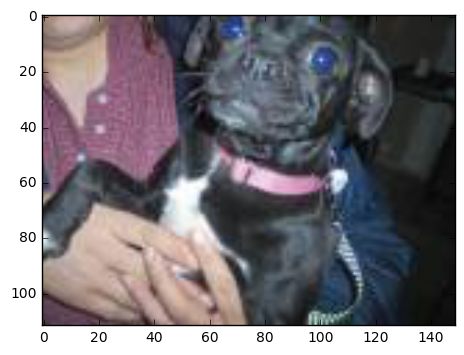

In [48]:
import os, os.path, random

# Load raw image file into memory
path = 'data/test/unknown'
files = os.listdir(path)
pathToFileInDisk = os.path.join(path,files[random.randrange(0, len(files))])
print(pathToFileInDisk)
with open( pathToFileInDisk, 'rb' ) as f:
    data = f.read()
    
# Computer Vision parameters
params = { 'visualFeatures' : 'Color,Categories,Tags'} 

headers = dict()
headers['Ocp-Apim-Subscription-Key'] = _key
headers['Content-Type'] = 'application/octet-stream'

json = None

result = processRequest( json, data, headers, params )

if result is not None:
    # Load the original image, fetched from the URL
    data8uint = np.fromstring( data, np.uint8 ) # Convert string to an unsigned int array
    img = cv2.cvtColor( cv2.imdecode( data8uint, cv2.IMREAD_COLOR ), cv2.COLOR_BGR2RGB )
    ig, ax = plt.subplots()
    ax.imshow( img )
    print_result(result)

## Analysis of an image retrieved via URL

Tags:
water(0.99964427948) 
sport(0.950499236584) 
swimming(0.90628182888) 
pool(0.878758847713) 
water sport(0.631849467754) 

Categories:
people_swimming(0.98046875) 


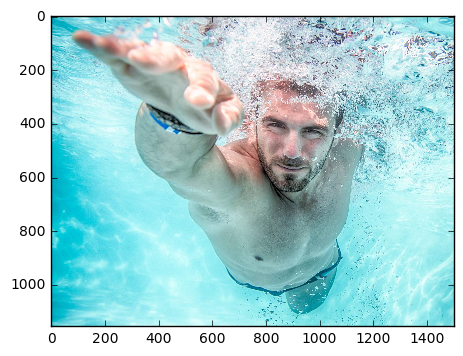

In [46]:
# URL direction to image
urlImage = 'https://oxfordportal.blob.core.windows.net/vision/Analysis/1.jpg'

# Computer Vision parameters
params = { 'visualFeatures' : 'Color,Categories,Tags'} 

headers = dict()
headers['Ocp-Apim-Subscription-Key'] = _key
headers['Content-Type'] = 'application/json' 

req_json = { 'url': urlImage } 
data = None

result = processRequest( req_json, data, headers, params )

if result is not None:
    # Load the original image, fetched from the URL
    arr = np.asarray( bytearray( requests.get( urlImage ).content ), dtype=np.uint8 )
    img = cv2.cvtColor( cv2.imdecode( arr, -1 ), cv2.COLOR_BGR2RGB )
    ig, ax = plt.subplots()
    ax.imshow( img )
    print_result(result)